In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tidy3d as td
import tidy3d.web as web
from tidy3d.plugins.dispersion import DispersionFitter

web.configure("SABeJ5wgzepP5RFT7HLhUdTp7g1g1CxPjjYJIAOCgqxrxKeB")

Configured successfully.


In [2]:
lda0 = 0.57  # operation wavelength
freq0 = td.C_0 / lda0  # operation frequency

In [7]:
fname = "McPeak.csv"  # read the refractive index data from a csv file
fitter = DispersionFitter.from_file(fname, delimiter=",")  # construct a fitter
al, rms_error = fitter.fit(num_poles=6, tolerance_rms=2e-2, num_tries=50)

/home/elexd/.local/lib/python3.10/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [8]:
# L_f is the length of the feed element
# r is the radius of the nanorods.
# medium is the material of the nanorods
def construct_antenna(L_f, r, lda0, medium):
    L_r = L_f * 1.25  # length of the reflector
    L_d = L_f * 0.9  # length of the directors
    a_r = lda0 / 4.4  # spacing between the feed and the reflector
    a_d = (
        lda0 / 4
    )  # spacing between the feed and the first director (also the spacing between directors)

    feed = [
        td.Structure(
            geometry=td.Cylinder(
                center=(0, 0, 0), radius=r, length=L_f - 2 * r, axis=1
            ),
            medium=medium,
        ),
        td.Structure(
            geometry=td.Sphere(center=(0, (L_f - 2 * r) / 2, 0), radius=r),
            medium=medium,
        ),
        td.Structure(
            geometry=td.Sphere(center=(0, -(L_f - 2 * r) / 2, 0), radius=r),
            medium=medium,
        ),
    ]

    reflector = [
        td.Structure(
            geometry=td.Cylinder(
                center=(-a_r, 0, 0), radius=r, length=L_r - 2 * r, axis=1
            ),
            medium=medium,
        ),
        td.Structure(
            geometry=td.Sphere(center=(-a_r, (L_r - 2 * r) / 2, 0), radius=r),
            medium=medium,
        ),
        td.Structure(
            geometry=td.Sphere(center=(-a_r, -(L_r - 2 * r) / 2, 0), radius=r),
            medium=medium,
        ),
    ]

    director_1 = [
        td.Structure(
            geometry=td.Cylinder(
                center=(a_d, 0, 0), radius=r, length=L_d - 2 * r, axis=1
            ),
            medium=medium,
        ),
        td.Structure(
            geometry=td.Sphere(center=(a_d, (L_d - 2 * r) / 2, 0), radius=r),
            medium=medium,
        ),
        td.Structure(
            geometry=td.Sphere(center=(a_d, -(L_d - 2 * r) / 2, 0), radius=r),
            medium=medium,
        ),
    ]

    director_2 = [
        td.Structure(
            geometry=td.Cylinder(
                center=(2 * a_d, 0, 0), radius=r, length=L_d - 2 * r, axis=1
            ),
            medium=medium,
        ),
        td.Structure(
            geometry=td.Sphere(center=(2 * a_d, (L_d - 2 * r) / 2, 0), radius=r),
            medium=medium,
        ),
        td.Structure(
            geometry=td.Sphere(center=(2 * a_d, -(L_d - 2 * r) / 2, 0), radius=r),
            medium=medium,
        ),
    ]

    director_3 = [
        td.Structure(
            geometry=td.Cylinder(
                center=(3 * a_d, 0, 0), radius=r, length=L_d - 2 * r, axis=1
            ),
            medium=medium,
        ),
        td.Structure(
            geometry=td.Sphere(center=(3 * a_d, (L_d - 2 * r) / 2, 0), radius=r),
            medium=medium,
        ),
        td.Structure(
            geometry=td.Sphere(center=(3 * a_d, -(L_d - 2 * r) / 2, 0), radius=r),
            medium=medium,
        ),
    ]

    antenna = feed + reflector + director_1 + director_2 + director_3
    return antenna


L_f = 0.16  # length of the feed
r = 0.02  # radius of the nanorods
medium = al  # material of the antenna

antenna = construct_antenna(L_f, r, lda0, medium)

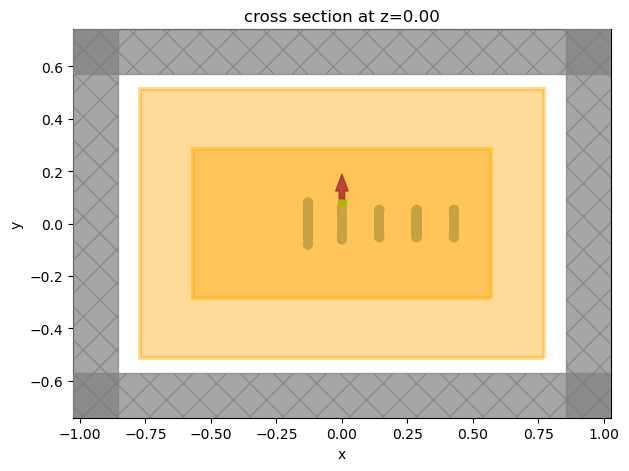

In [9]:
# define simulation domain size
Lx = 3 * lda0
Ly = 2 * lda0
Lz = 2 * lda0
sim_size = (Lx, Ly, Lz)

# create an electrical point dipole source polarized in the y direction to excite the feed element
d_dp = 0.004  # distance between the dipole and the feed element
pulse = td.GaussianPulse(freq0=freq0, fwidth=freq0 / 20)
pt_dipole = td.PointDipole(
    center=(0, L_f / 2 + d_dp, 0), source_time=pulse, polarization="Ey"
)

# create a FieldProjectionAngleMonitor to perform the near field to far field transformation in spherical coordinates
theta_array = np.linspace(0, 2 * np.pi, 200)
phi_array = np.linspace(0, np.pi, 100)
n2f_monitor = td.FieldProjectionAngleMonitor(
    center=(0, 0, 0),
    size=(2 * lda0, 1 * lda0, 1 * lda0),
    freqs=[freq0],
    name="n2f_monitor",
    custom_origin=(0, 0, 0),
    phi=phi_array,
    theta=theta_array,
)

# create a flux monitor to calculate the total radiated power
flux_monitor = td.FluxMonitor(
    center=(0, 0, 0),
    size=(Lx * 0.9, Ly * 0.9, Lz * 0.9),
    freqs=[freq0],
    name="power",
)

# create the simulation with the above defined elements
sim = td.Simulation(
    center=(0, 0, 0),
    size=sim_size,
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=40, wavelength=lda0),
    structures=antenna,
    sources=[pt_dipole],
    monitors=[n2f_monitor, flux_monitor],
    run_time=1e-13,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
)

# visualize the simulation setup
sim.plot(z=0)
plt.show()

In [10]:
sim_empty = td.Simulation(
    center=(0, 0, 0),
    size=sim_size,
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=40, wavelength=lda0),
    structures=[],  # this simulation is identical to the previous one besides the structures is set to an empty list
    sources=[pt_dipole],
    monitors=[n2f_monitor, flux_monitor],
    run_time=1e-13,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
)

In [11]:
sim_data = web.run(
    sim, task_name="plasmonic_yagi_uda", path="data/optical_yagi_uda.hdf5", verbose=True
)
sim_empty_data = web.run(
    sim_empty, task_name="empty", path="data/optical_yagi_uda.hdf5", verbose=True
)

00:26:49 +07 Created task 'plasmonic_yagi_uda' with task_id                     
             'fdve-a1bc7840-9a72-4caf-ac1a-6d7ee02f060e' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=766068;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a1bc7840-9a72-4caf-ac1a-6d7ee02f060e\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=76577;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a1bc7840-9a72-4caf-ac1a-6d7ee02f060e\taskId]8;;\]8;id=766068;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a1bc7840-9a72-4caf-ac1a-6d7ee02f060e\=]8;;\]8;id=916877;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a1bc7840-9a72-4caf-ac1a-6d7ee02f060e\fdve]8;;\]8;id=766068;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a1bc7840-9a72-4caf-ac1a-6d7ee02f060e\-a1bc7840-9a7]8;;\
             ]8;id=766068;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a1bc7840-9a72-4caf-ac1a-6d7ee02f060e\2-4caf-ac1a-6d7ee02f060e']8;;\.

/home/elexd/.local/lib/python3.10/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

00:26:53 +07 status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

00:27:01 +07 status = preprocess

00:27:03 +07 Maximum FlexCredit cost: 0.056. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

00:27:23 +07 early shutoff detected at 56%, exiting.

             status = postprocess

00:27:24 +07 status = success

00:27:25 +07 View simulation result at                                          
             ]8;id=337378;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a1bc7840-9a72-4caf-ac1a-6d7ee02f060e\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=85515;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a1bc7840-9a72-4caf-ac1a-6d7ee02f060e\taskId]8;;\]8;id=337378;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a1bc7840-9a72-4caf-ac1a-6d7ee02f060e\=]8;;\]8;id=466143;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a1bc7840-9a72-4caf-ac1a-6d7ee02f060e\fdve]8;;\]8;id=337378;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a1bc7840-9a72-4caf-ac1a-6d7ee02f060e\-a1bc7840-9a7]8;;\
             ]8;id=337378;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a1bc7840-9a72-4caf-ac1a-6d7ee02f060e\2-4caf-ac1a-6d7ee02f060e']8;;\.

00:27:27 +07 loading simulation from data/optical_yagi_uda.hdf5

00:27:28 +07 Created task 'empty' with task_id                                  
             'fdve-6dec5807-9289-4195-9b3a-5fbc516fd961' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=98904;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6dec5807-9289-4195-9b3a-5fbc516fd961\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=512805;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6dec5807-9289-4195-9b3a-5fbc516fd961\taskId]8;;\]8;id=98904;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6dec5807-9289-4195-9b3a-5fbc516fd961\=]8;;\]8;id=17564;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6dec5807-9289-4195-9b3a-5fbc516fd961\fdve]8;;\]8;id=98904;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6dec5807-9289-4195-9b3a-5fbc516fd961\-6dec5807-928]8;;\
             ]8;id=98904;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6dec5807-9289-4195-9b3a-5fbc516fd961\9-4195-9b3a-5fbc516fd961']8;;\.

/home/elexd/.local/lib/python3.10/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

00:27:31 +07 status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

00:27:34 +07 status = preprocess

00:27:36 +07 Maximum FlexCredit cost: 0.025. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

00:27:41 +07 early shutoff detected at 52%, exiting.

00:27:42 +07 status = postprocess

             status = success

00:27:43 +07 View simulation result at                                          
             ]8;id=894708;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6dec5807-9289-4195-9b3a-5fbc516fd961\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=573;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6dec5807-9289-4195-9b3a-5fbc516fd961\taskId]8;;\]8;id=894708;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6dec5807-9289-4195-9b3a-5fbc516fd961\=]8;;\]8;id=699897;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6dec5807-9289-4195-9b3a-5fbc516fd961\fdve]8;;\]8;id=894708;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6dec5807-9289-4195-9b3a-5fbc516fd961\-6dec5807-928]8;;\
             ]8;id=894708;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6dec5807-9289-4195-9b3a-5fbc516fd961\9-4195-9b3a-5fbc516fd961']8;;\.

00:27:50 +07 loading simulation from data/optical_yagi_uda.hdf5

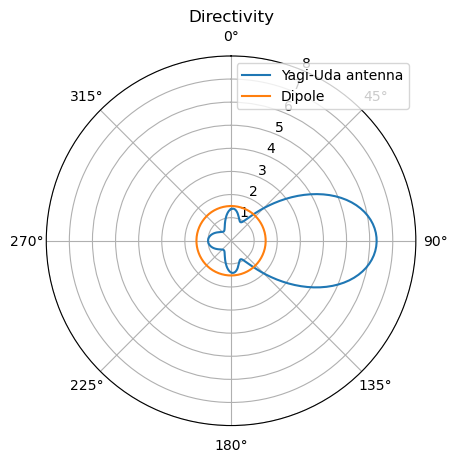

In [12]:
P0 = np.array(sim_data["power"].flux)  # total radiated power of the yagi-uda antenna

# angular radiated power of the yagi-uda antenna
# by default, the power is calculated at 1 meter away from the antenna. The 1e12 factor normalizes the power to unit distance (1 um)
P = 1e12 * sim_data["n2f_monitor"].power.sel(f=freq0, phi=0, method="nearest").values
P = np.squeeze(P)
D = 4 * np.pi * P / P0  # directivity of the yagi-uda antenna

P0_dp = np.array(
    sim_empty_data["power"].flux
)  # total radiated power of the point dipole
P_dp = (
    1e12
    * sim_empty_data["n2f_monitor"].power.sel(f=freq0, phi=0, method="nearest").values
)  # angular radiated power of the point dipole
P_dp = np.squeeze(P_dp)
D_dp = 4 * np.pi * P_dp / P0_dp  # directivity of the point dipole

# comparison of the directivity
fig, ax = plt.subplots(subplot_kw={"projection": "polar"})
ax.set_theta_direction(-1)
ax.set_theta_offset(np.pi / 2.0)
ax.plot(theta_array, D, theta_array, D_dp)
ax.set_rlim(0, 8)
ax.set_title("Directivity")
ax.legend(("Yagi-Uda antenna", "Dipole"))
plt.show()

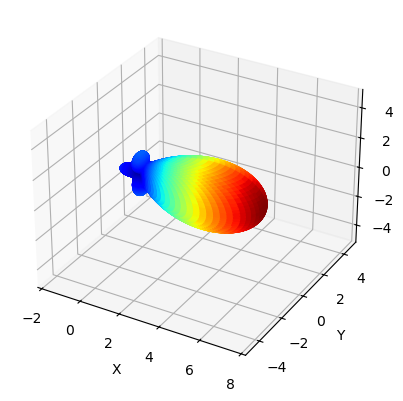

In [13]:
P = 1e12 * sim_data["n2f_monitor"].power.sel(f=freq0).values  # angular radiated power
D = 4 * np.pi * np.squeeze(P) / P0  # directivity

# convert the spherical coordinates representation to cartesian coordinates
phi, theta = np.meshgrid(phi_array, theta_array)
X = D * np.cos(phi) * np.sin(theta)
Y = D * np.sin(phi) * np.sin(theta)
Z = D * np.cos(theta)

R = np.sqrt(
    X**2 + Y**2 + Z**2
)  # distance to the center will be used to plot the color on top of the radiation pattern
R = R / np.max(R)  # normalize it to 1

color = plt.cm.jet(R)  # define colormap using the distance

# plotting the radiation pattern in 3d
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection="3d")
ax.set_xlim((-2, 8))
ax.set_ylim((-5, 5))
ax.set_zlim((-5, 5))
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
surf = ax.plot_surface(
    X, Y, Z, cstride=1, rstride=1, facecolors=color, antialiased=True, shade=False
)

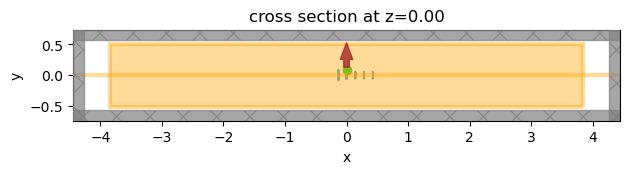

In [14]:
# compared to the previous simulation, this simulation uses a much larger simulation domain size
Lx = 15 * lda0
Ly = 2 * lda0
Lz = 15 * lda0
sim_size = (Lx, Ly, Lz)

# add a point dipole source
pulse = td.GaussianPulse(freq0=freq0, fwidth=freq0 / 20)
pt_dipole = td.PointDipole(
    center=(0, L_f / 2 + d_dp, 0), source_time=pulse, polarization="Ey"
)

# add a flux monitor to compute the total radiated power
flux_monitor = td.FluxMonitor(
    center=(0, 0, 0),
    size=(Lx * 0.9, Ly * 0.9, Lz * 0.9),
    freqs=[freq0],
    name="power",
)

# add a field monitor to compute the field far away from the antenna to calculate the directivity
field_monitor = td.FieldMonitor(
    center=(0, 0, 0),
    size=(td.inf, 0, td.inf),
    freqs=[freq0],
    name="field",
)

# create the simulation with the above defined elements
sim = td.Simulation(
    center=(0, 0, 0),
    size=sim_size,
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=40, wavelength=lda0),
    structures=antenna,
    sources=[pt_dipole],
    monitors=[flux_monitor, field_monitor],
    run_time=1e-13,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
)

# visualize the simulation setup
sim.plot(z=0)
plt.show()

In [15]:
sim_data = web.run(
    sim, task_name="plasmonic_yagi_uda", path="data/optical_yagi_uda.hdf5", verbose=True
)

00:29:11 +07 Created task 'plasmonic_yagi_uda' with task_id                     
             'fdve-15c76de6-0685-446d-b18a-bfaaefe1cb34' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=176316;https://tidy3d.simulation.cloud/workbench?taskId=fdve-15c76de6-0685-446d-b18a-bfaaefe1cb34\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=968910;https://tidy3d.simulation.cloud/workbench?taskId=fdve-15c76de6-0685-446d-b18a-bfaaefe1cb34\taskId]8;;\]8;id=176316;https://tidy3d.simulation.cloud/workbench?taskId=fdve-15c76de6-0685-446d-b18a-bfaaefe1cb34\=]8;;\]8;id=655299;https://tidy3d.simulation.cloud/workbench?taskId=fdve-15c76de6-0685-446d-b18a-bfaaefe1cb34\fdve]8;;\]8;id=176316;https://tidy3d.simulation.cloud/workbench?taskId=fdve-15c76de6-0685-446d-b18a-bfaaefe1cb34\-15c76de6-068]8;;\
             ]8;id=176316;https://tidy3d.simulation.cloud/workbench?taskId=fdve-15c76de6-0685-446d-b18a-bfaaefe1cb34\5-446d-b18a-bfaaefe1cb34']8;;\.

/home/elexd/.local/lib/python3.10/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

00:29:14 +07 status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

00:29:20 +07 status = preprocess

00:29:22 +07 Maximum FlexCredit cost: 0.744. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

00:30:07 +07 early shutoff detected at 64%, exiting.

             status = postprocess

00:30:09 +07 status = success

00:30:10 +07 View simulation result at                                          
             ]8;id=430206;https://tidy3d.simulation.cloud/workbench?taskId=fdve-15c76de6-0685-446d-b18a-bfaaefe1cb34\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=524671;https://tidy3d.simulation.cloud/workbench?taskId=fdve-15c76de6-0685-446d-b18a-bfaaefe1cb34\taskId]8;;\]8;id=430206;https://tidy3d.simulation.cloud/workbench?taskId=fdve-15c76de6-0685-446d-b18a-bfaaefe1cb34\=]8;;\]8;id=75028;https://tidy3d.simulation.cloud/workbench?taskId=fdve-15c76de6-0685-446d-b18a-bfaaefe1cb34\fdve]8;;\]8;id=430206;https://tidy3d.simulation.cloud/workbench?taskId=fdve-15c76de6-0685-446d-b18a-bfaaefe1cb34\-15c76de6-068]8;;\
             ]8;id=430206;https://tidy3d.simulation.cloud/workbench?taskId=fdve-15c76de6-0685-446d-b18a-bfaaefe1cb34\5-446d-b18a-bfaaefe1cb34']8;;\.

00:30:20 +07 loading simulation from data/optical_yagi_uda.hdf5

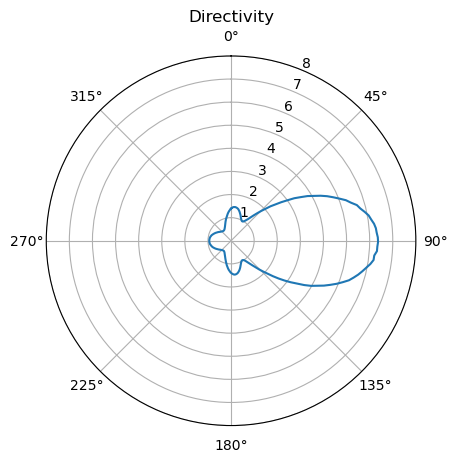

In [16]:
d = 7 * lda0  # distance at which the radiation pattern is evaluated
Z0 = 377  # free space impedance
P0 = np.array(sim_data["power"].flux)  # total radiated power

# evaluate the radiated power at 7*lda0 away from the antenna
P = np.zeros(len(theta_array))
for i, theta in enumerate(theta_array):
    Ex = sim_data["field"].Ex.sel(
        x=d * np.sin(theta), z=d * np.cos(theta), method="nearest"
    )
    Ey = sim_data["field"].Ey.sel(
        x=d * np.sin(theta), z=d * np.cos(theta), method="nearest"
    )
    Ez = sim_data["field"].Ez.sel(
        x=d * np.sin(theta), z=d * np.cos(theta), method="nearest"
    )
    P[i] = (
        d**2 * (abs(Ex) ** 2 + abs(Ey) ** 2 + abs(Ez) ** 2) / (2 * Z0)
    )  # we multiple the power by d^2 to normalize it to the power at unit distance
D = 4 * np.pi * P / P0  # directivity of the yagi-uda antenna

fig, ax = plt.subplots(subplot_kw={"projection": "polar"})
ax.set_theta_direction(-1)
ax.set_theta_offset(np.pi / 2.0)
ax.plot(theta_array, D)
ax.set_rlim(0, 8)
ax.set_title("Directivity")
plt.show()

In [17]:
pec = td.PECMedium()  # pec medium

n_glass = 1.5  # glass has a refractive index of 1.5
glass = td.Medium(permittivity=n_glass**2)

L_f = 0.187  # length of the feed element
antenna_pec = construct_antenna(
    L_f, r, lda0, pec
)  # construct the lossless yagi-uda antenna with pec

inf_eff = 100  # effective infinity
# construct the substrate
sub = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-inf_eff, -inf_eff, -inf_eff), rmax=(inf_eff, inf_eff, -r)
    ),
    medium=glass,
)

# the whole structure is the antenna plus the substrate
antenna_pec.append(sub)

# to control the mesh around the antenna area, we construct a mesh override structure
# refractive index of the override structure is set to 10 to ensure sufficiently but not excessively fine mesh
refine_medium = td.Medium(permittivity=10**2)
antenna_refine = construct_antenna(
    L_f, r, lda0, refine_medium
)  # construct the mesh override structure

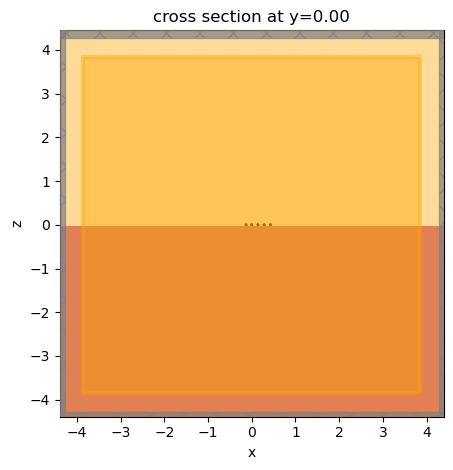

In [18]:
Lx = 15 * lda0
Ly = 2 * lda0
Lz = 15 * lda0
sim_size = (Lx, Ly, Lz)

pulse = td.GaussianPulse(freq0=freq0, fwidth=freq0 / 20)
pt_dipole = td.PointDipole(
    center=(0, L_f / 2 + d_dp, 0), source_time=pulse, polarization="Ey"
)

flux_monitor = td.FluxMonitor(
    center=(0, 0, 0),
    size=(Lx * 0.9, Ly * 0.9, Lz * 0.9),
    freqs=[freq0],
    name="power",
)

field_monitor = td.FieldMonitor(
    center=(0, 0, 0),
    size=(td.inf, 0, td.inf),
    freqs=[freq0],
    name="field",
)

sim = td.Simulation(
    center=(0, 0, 0),
    size=sim_size,
    grid_spec=td.GridSpec.auto(
        min_steps_per_wvl=40, wavelength=lda0, override_structures=antenna_refine
    ),
    structures=antenna_pec,
    sources=[pt_dipole],
    monitors=[flux_monitor, field_monitor],
    run_time=1e-13,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
)

sim.plot(y=0)
plt.show()

In [19]:
sim_data = web.run(
    sim,
    task_name="plasmonic_yagi_uda_on_glass",
    path="data/optical_yagi_uda.hdf5",
    verbose=True,
)

00:31:42 +07 Created task 'plasmonic_yagi_uda_on_glass' with task_id            
             'fdve-725b2dc6-8d96-4f64-9c50-bd75099ae203' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=455413;https://tidy3d.simulation.cloud/workbench?taskId=fdve-725b2dc6-8d96-4f64-9c50-bd75099ae203\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=779432;https://tidy3d.simulation.cloud/workbench?taskId=fdve-725b2dc6-8d96-4f64-9c50-bd75099ae203\taskId]8;;\]8;id=455413;https://tidy3d.simulation.cloud/workbench?taskId=fdve-725b2dc6-8d96-4f64-9c50-bd75099ae203\=]8;;\]8;id=591446;https://tidy3d.simulation.cloud/workbench?taskId=fdve-725b2dc6-8d96-4f64-9c50-bd75099ae203\fdve]8;;\]8;id=455413;https://tidy3d.simulation.cloud/workbench?taskId=fdve-725b2dc6-8d96-4f64-9c50-bd75099ae203\-725b2dc6-8d9]8;;\
             ]8;id=455413;https://tidy3d.simulation.cloud/workbench?taskId=fdve-725b2dc6-8d96-4f64-9c50-bd75099ae203\6-4f64-9c50-bd75099ae203']8;;\.

/home/elexd/.local/lib/python3.10/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

00:31:45 +07 status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

00:31:49 +07 status = preprocess

00:31:51 +07 Maximum FlexCredit cost: 4.546. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

00:33:56 +07 early shutoff detected at 76%, exiting.

00:33:57 +07 status = postprocess

00:34:01 +07 status = success

             View simulation result at                                          
             ]8;id=574560;https://tidy3d.simulation.cloud/workbench?taskId=fdve-725b2dc6-8d96-4f64-9c50-bd75099ae203\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=730728;https://tidy3d.simulation.cloud/workbench?taskId=fdve-725b2dc6-8d96-4f64-9c50-bd75099ae203\taskId]8;;\]8;id=574560;https://tidy3d.simulation.cloud/workbench?taskId=fdve-725b2dc6-8d96-4f64-9c50-bd75099ae203\=]8;;\]8;id=477934;https://tidy3d.simulation.cloud/workbench?taskId=fdve-725b2dc6-8d96-4f64-9c50-bd75099ae203\fdve]8;;\]8;id=574560;https://tidy3d.simulation.cloud/workbench?taskId=fdve-725b2dc6-8d96-4f64-9c50-bd75099ae203\-725b2dc6-8d9]8;;\
             ]8;id=574560;https://tidy3d.simulation.cloud/workbench?taskId=fdve-725b2dc6-8d96-4f64-9c50-bd75099ae203\6-4f64-9c50-bd75099ae203']8;;\.

00:35:25 +07 loading simulation from data/optical_yagi_uda.hdf5

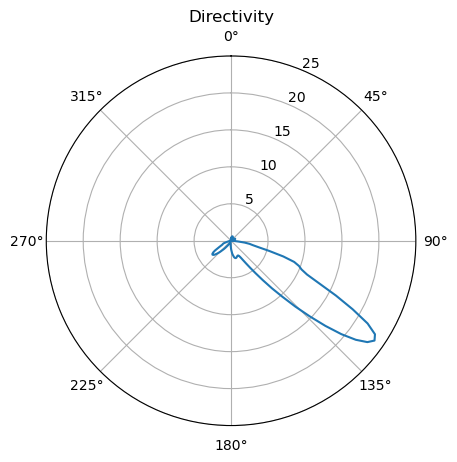

In [20]:
P0 = np.array(sim_data["power"].flux)  # total radiated power

# evaluate the radiated power at 7*lda0 away from the antenna
P = np.zeros(len(theta_array))
for i, theta in enumerate(theta_array):
    Ex = sim_data["field"].Ex.sel(
        x=d * np.sin(theta), z=d * np.cos(theta), method="nearest"
    )
    Ey = sim_data["field"].Ey.sel(
        x=d * np.sin(theta), z=d * np.cos(theta), method="nearest"
    )
    Ez = sim_data["field"].Ez.sel(
        x=d * np.sin(theta), z=d * np.cos(theta), method="nearest"
    )
    if d * np.cos(theta) > 0:
        P[i] = d**2 * (abs(Ex) ** 2 + abs(Ey) ** 2 + abs(Ez) ** 2) / (2 * Z0)
    else:
        # inside the substrate, the impedance of the glass needs to be taken into account
        P[i] = (
            n_glass * d**2 * (abs(Ex) ** 2 + abs(Ey) ** 2 + abs(Ez) ** 2) / (2 * Z0)
        )

D = 4 * np.pi * P / P0  # directivity

# plotting the directivity pattern
fig, ax = plt.subplots(subplot_kw={"projection": "polar"})
ax.set_theta_direction(-1)
ax.set_theta_offset(np.pi / 2.0)
ax.plot(theta_array, D)
ax.set_rlim(0, 25)
ax.set_title("Directivity")
plt.show()